In [207]:
import tensorflow as tf
import torch

In [208]:
from keras.datasets import mnist

In [209]:
import matplotlib.pyplot as plt
import numpy as np

In [210]:
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
print(f"Using device: {device}")
     

Using device: mps


In [211]:
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.mnist.load_data()

In [212]:
print('The shape of the training inputs:', X_train.shape)
print('The shape of the training labels:',y_train.shape)
print('The shape of the testing inputs:',X_test.shape)
print('The shape of the testing labels:',y_test.shape)

The shape of the training inputs: (60000, 28, 28)
The shape of the training labels: (60000,)
The shape of the testing inputs: (10000, 28, 28)
The shape of the testing labels: (10000,)


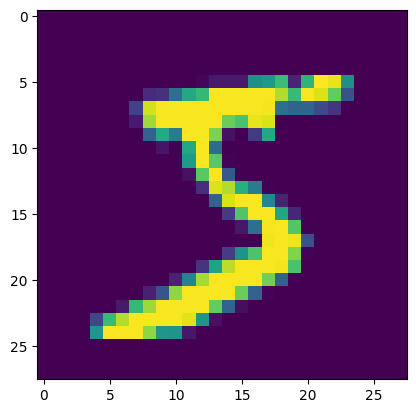

In [213]:
plt.imshow(X_train[0])

In [214]:
X_train=X_train/255
X_test=X_test/255

In [215]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).squeeze(1)
y_train_tensor = torch.tensor(y_train,dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test,dtype=torch.long)

In [216]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

In [217]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [218]:
import torch.nn.functional as F

In [219]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.fc1 = nn.Linear(28*28,256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256,128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
model = Model()

In [220]:
lossfn = nn.CrossEntropyLoss()


In [221]:
optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [222]:
nn.init.xavier_uniform_(model.fc1.weight)
nn.init.xavier_uniform_(model.fc2.weight)
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.xavier_uniform_(model.fc4.weight)

Parameter containing:
tensor([[ 2.4391e-01, -2.4554e-01, -2.1245e-01,  2.7901e-01,  1.8426e-01,
          1.2769e-01, -1.4272e-01,  2.5607e-01,  1.0966e-01, -6.7790e-02,
         -1.0243e-01,  8.5761e-02,  3.8472e-02, -2.6530e-01,  1.4527e-01,
         -4.0749e-02, -2.1439e-02,  1.8896e-01, -2.0772e-01, -2.8142e-02,
         -6.7891e-02,  1.8604e-01, -3.3937e-02,  2.5318e-01, -2.6316e-01,
          9.7086e-02, -1.1292e-01,  1.9379e-01,  2.6231e-01, -2.8402e-01,
          1.2626e-01,  1.3437e-01, -1.6245e-01,  1.8374e-02,  1.2228e-01,
          1.0089e-01,  1.5082e-01, -6.1827e-02, -2.0730e-01, -2.5432e-01,
          2.3642e-03,  5.2812e-02, -2.1397e-01, -1.8827e-01,  3.0323e-03,
         -1.9561e-01, -2.4990e-01, -1.1344e-01, -2.1007e-01,  1.9443e-01,
          2.0031e-01, -4.2622e-02,  3.6977e-02,  2.4387e-03,  3.6070e-03,
         -1.7979e-01,  6.3150e-02, -1.5160e-01,  1.8459e-01,  1.6143e-02,
         -8.0454e-02, -6.3921e-02,  1.0456e-01, -1.3418e-02],
        [-9.6504e-02, -1.389

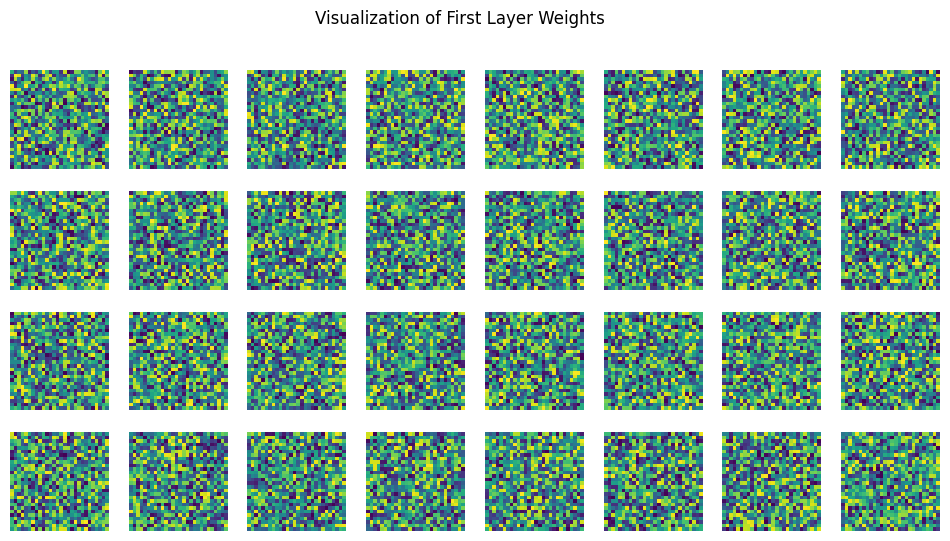

In [223]:
# Extract weights from first fully connected layer
weights = model.fc1.weight.data

# Plot a few neurons' weights as 28x28 images
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < weights.shape[0]:
        ax.imshow(weights[i].reshape(28, 28), cmap='viridis')
        ax.axis('off')
plt.suptitle("Visualization of First Layer Weights")
plt.show()


In [224]:
#training loop
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss=0

    for image,labels in train_loader:
        
        #set gradients as zero
        optimizer.zero_grad()

        #forward pass
        outputs = model(image)
        loss = lossfn(outputs,labels)

        #backward pass
        loss.backward()

        #optimiser
        optimizer.step()

        running_loss += loss.item()

    if epoch%5==0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):4f}")
    

Epoch 1/10, Loss: 0.961869
Epoch 6/10, Loss: 0.186793


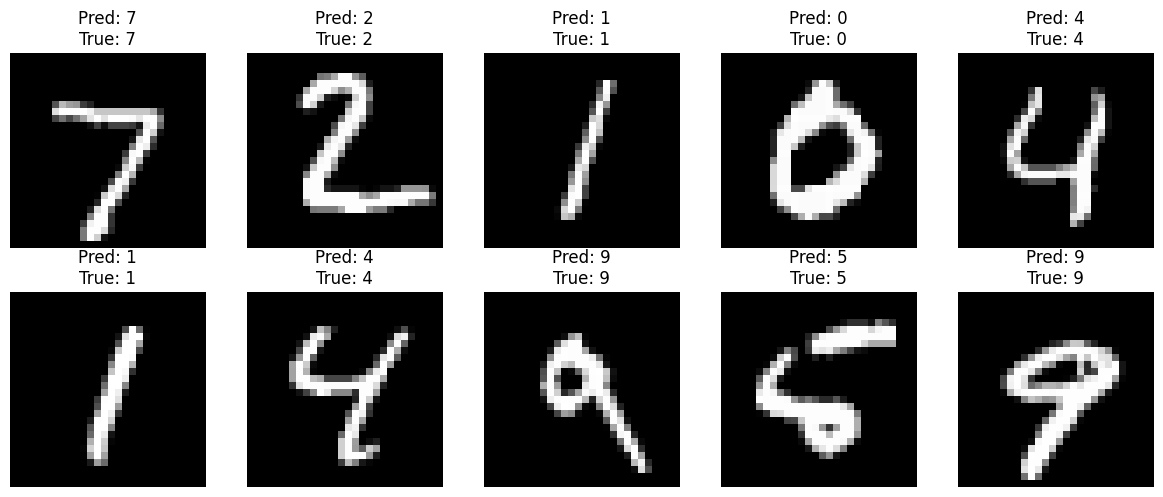

In [225]:
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        break  # Just the first batch

# Plot the first 10 test images and their predictions
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"Pred: {predicted[i].item()}\nTrue: {labels[i].item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [226]:
model.eval()
correct = 0
total=0
wrong=[]
with torch.no_grad():
    for images,labels in test_loader:
        outputs=model(images)

        _,predicted = torch.max(outputs,1)
        total+=labels.size(0)
        correct += (predicted == labels).sum().item() 
        
        for i in range(len(labels)):
            if predicted[i]!=labels[i]:
                wrong.append((images[i], predicted[i], labels[i]))
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 97.71%


In [227]:
len(wrong)

229

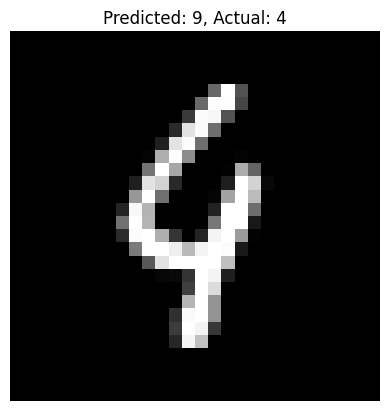

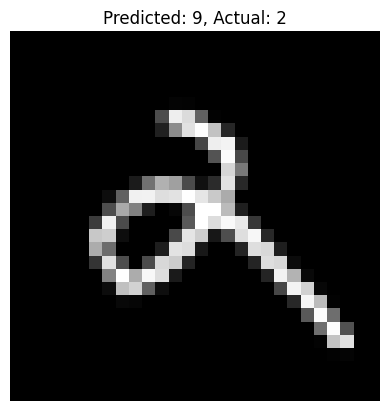

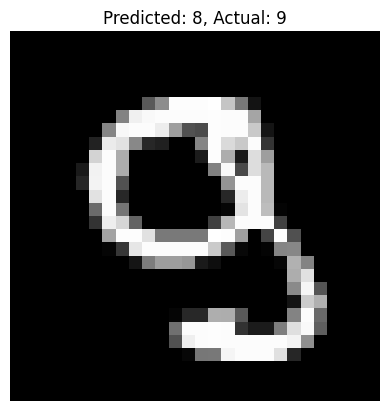

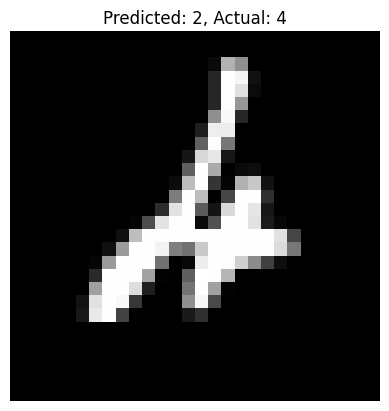

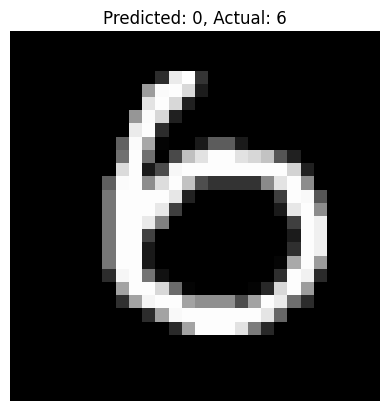

In [228]:
for i in range(5):
    img, pred, true = wrong[i]
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Predicted: {pred.item()}, Actual: {true.item()}")
    plt.axis('off')
    plt.show()